# Combining tiles

In [8]:
import glob
import distributed
import numpy as np

dirname = "/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF"

## Request resources

In [2]:
import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(
    project="ncgd0011", 
    #scheduler_options=dict(dashboard_address=":9797"),
    cores=1,  # The number of cores you want
    memory="12GB",  # Amount of memory
    processes=1,  # How many processes
    queue="casper",  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory="$TMPDIR",  # Use your local directory
    resource_spec="select=1:ncpus=1:mem=12GB",  # Specify resources
    walltime="04:00:00",
)
cluster

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42221 instead
  warnings.warn(


In [15]:
client = distributed.Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/42221/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/42221/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:35854,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/42221/status,Total threads: 0
Started: 5 minutes ago,Total memory: 0 B


In [16]:
cluster.scale(2)

## Note

The files are stored under paths that look like

```
'/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0118',
'/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0119',
'/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0120',
`/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0121',
...
```

## Test out combining

Here's what the files for a single day looks like.

In [12]:
pattern = "1993_001"
files = sorted(glob.glob(f"{dirname}/*{pattern}*"))[:30]
files

['/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0118',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0119',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0120',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0121',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0122',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0123',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0136',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0137',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0138',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHELF/ocean_shelf__1993_001.nc.0139',
 '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/SHEL

Lets read the raw files using `read_raw_files`

In [ ]:
from mom6_tools.sections import read_raw_files
dsets = read_raw_files(files, parallel=True)

This returns a 1D list of Datasets

In [18]:
dsets

[<xarray.Dataset>
 Dimensions:        (xq: 51, yh: 35, z_l: 140, z_i: 141, time: 8, nv: 2, xh: 51,
                     yq: 35)
 Coordinates:
   * xq             (xq) float64 263.0 263.1 263.1 263.1 ... 265.4 265.4 265.5
   * yh             (yh) float64 2.975 3.025 3.075 3.125 ... 4.575 4.625 4.675
   * z_l            (z_l) float64 1.25 3.75 6.25 ... 6.324e+03 6.574e+03
   * z_i            (z_i) float64 0.0 2.5 5.0 ... 6.199e+03 6.449e+03 6.699e+03
   * time           (time) object 1992-12-30 01:30:00 ... 1992-12-30 22:30:00
   * nv             (nv) float64 1.0 2.0
   * xh             (xh) float64 263.0 263.0 263.1 263.1 ... 265.4 265.4 265.5
   * yq             (yq) float64 3.0 3.05 3.1 3.15 3.2 ... 4.5 4.55 4.6 4.65 4.7
 Data variables: (12/16)
     uo             (time, z_l, yh, xq) float32 dask.array<chunksize=(8, 140, 35, 51), meta=np.ndarray>
     vo             (time, z_l, yq, xh) float32 dask.array<chunksize=(8, 140, 35, 51), meta=np.ndarray>
     thetao         (time, z_l, yh,

Now visualize the bounding boxes for each tile using a single variable

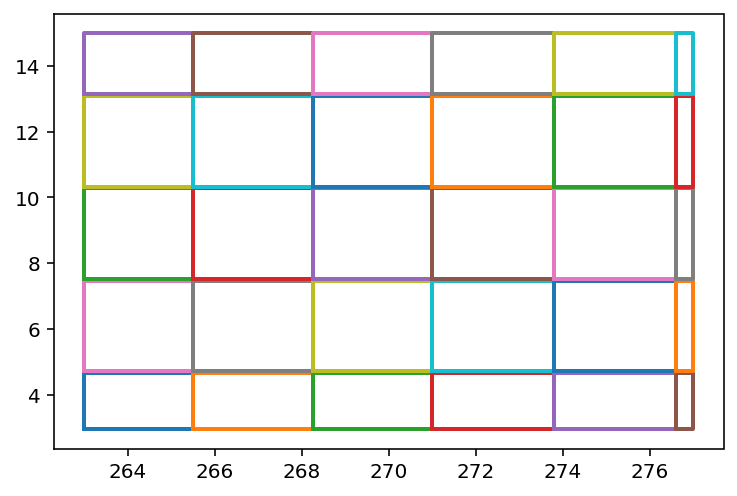

In [22]:
from mom6_sections import visualize_tile

for ds in dsets:
    visualize_tile(ds.uo)

Now lets combine those tiles into a single Dataset. For that we will first reshape our 1D list of Datasets into 2D tiles matching the figure above (6 along x, 5 along y)

In [31]:
from mom6_tools.sections import tile_raw_files

tiled = tile_raw_files(dsets, x=6, y=5)
print(f"ncols={len(tiled)}, nrows={len(tiled[0])}")

ncols=5, nrows=6


In [32]:
from mom6_tools.sections import combine_manual

In [33]:
combined = combine_manual(tiled)
combined

<xarray.Dataset>
Dimensions:        (xq: 281, yh: 241, z_l: 140, time: 8, xh: 281, yq: 241,
                    z_i: 141)
Coordinates:
  * xq             (xq) float64 263.0 263.1 263.1 263.1 ... 276.9 276.9 277.0
  * yh             (yh) float64 2.975 3.025 3.075 3.125 ... 14.88 14.93 14.98
  * z_l            (z_l) float64 1.25 3.75 6.25 ... 6.324e+03 6.574e+03
  * time           (time) object 1992-12-30 01:30:00 ... 1992-12-30 22:30:00
  * xh             (xh) float64 263.0 263.0 263.1 263.1 ... 276.9 276.9 277.0
  * yq             (yq) float64 3.0 3.05 3.1 3.15 3.2 ... 14.85 14.9 14.95 15.0
  * z_i            (z_i) float64 0.0 2.5 5.0 ... 6.199e+03 6.449e+03 6.699e+03
Data variables:
    uo             (time, z_l, yh, xq) float32 dask.array<chunksize=(8, 140, 35, 50), meta=np.ndarray>
    vo             (time, z_l, yq, xh) float32 dask.array<chunksize=(8, 140, 34, 51), meta=np.ndarray>
    thetao         (time, z_l, yh, xh) float32 dask.array<chunksize=(8, 140, 35, 51), meta=np.ndarray>
    so             (time, z_l, yh, xh) float32 dask.array<chunksize=(8, 140, 35, 51), meta=np.ndarray>
    Tflx_dia_diff  (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>
    Sflx_dia_diff  (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>
    Kd_heat        (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>
    Kd_salt        (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>
    Kd_ePBL        (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>
    Kd_shear       (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>
    Kv_u           (time, z_l, yh, xq) float32 dask.array<chunksize=(8, 140, 35, 50), meta=np.ndarray>
    Kd_BBL         (time, z_i, yh, xh) float32 dask.array<chunksize=(8, 141, 35, 51), meta=np.ndarray>

Make sure there are no artifacts

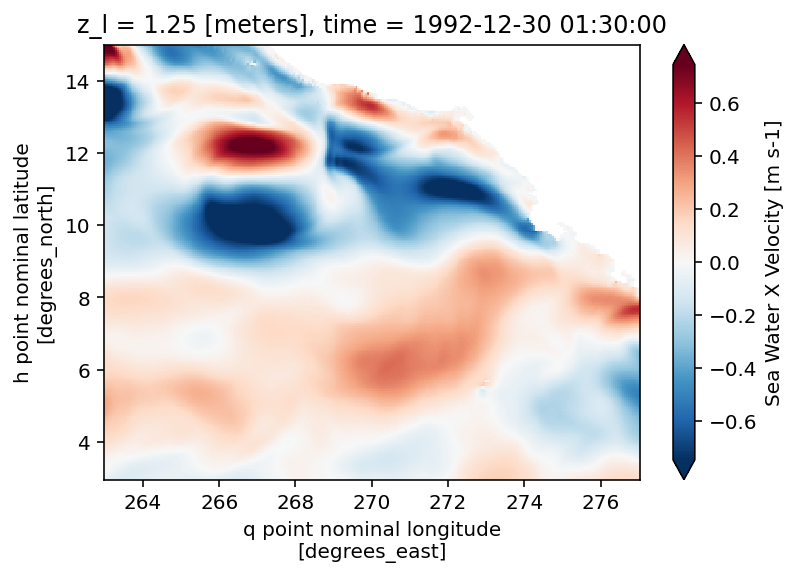

In [39]:
import cf_xarray

combined.uo.cf.isel(Z=0, T=0).plot(robust=True)

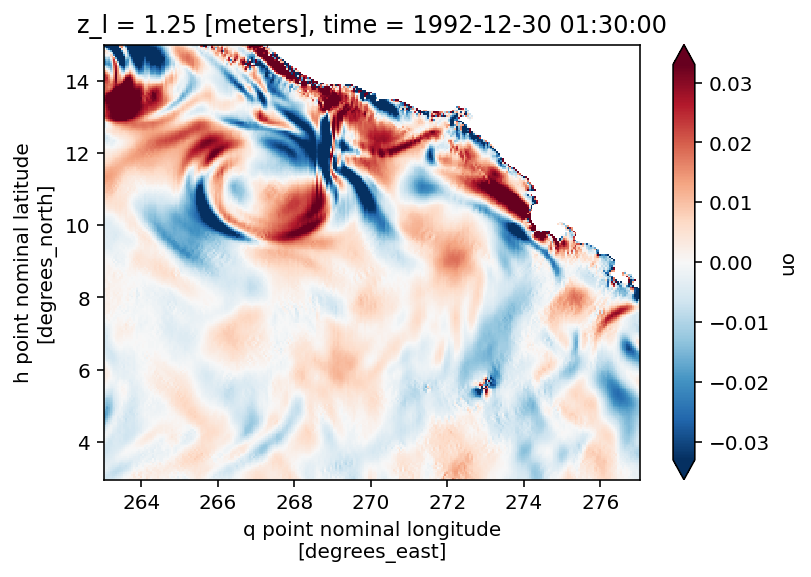

In [40]:
combined.uo.cf.isel(Z=0, T=0).cf.diff("X").plot(robust=True)

## Combine files in parallel

1. The idea is that we'll use `dask.delayed` to execute one task per day i.e. we parallelize across output files
1. This task will 
    - synchronously read in all files for that day using `read_raw_files`,
    - assemble them to one xarray.Dataset using `tile_raw_files` and `combine_manual`
    - write that Dataset to a new file with compression enabled
    
    
The following function does all these steps

In [6]:
def all_steps(pattern, dirname, scheduler="sync"):
    import glob
    import dask
    from mom_tools.sections import combine_manual, read_raw_files, tile_raw_files

    # compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
    # encoding = {var: {"compressor": compressor} for var in concat}

    # complevel=4 makes no difference
    compr_dict = dict(zlib=True, complevel=1, _FillValue=None)
    
    globstr = f"{dirname}/*{pattern}*"
    files = sorted(glob.glob(f"{dirname}/*{pattern}*"))

    with dask.config.set(scheduler=scheduler):
        # only parallelize if not being executed in a delayed task
        raw_files_list = read_raw_files(files, parallel= scheduler != "sync")
        if not raw_files_list:
            raise ValueError(f"bad pattern: {pattern}; reading {globstr}")

        nfiles = len(raw_files_list)
        # make sure number of files is what I expect
        if nfiles != 30:
            raise ValueError(f"wrong number of files {nfiles} for pattern: {pattern}")
            
        # reshape into 2D list of lists
        # then concatenate along rows, then columns
        combined1 = combine_manual(tile_raw_files(raw_files_list[:30], 6, 5))
        
        # write to file
        name = f"{dirname}/compressed/ocean_shelf_{pattern}.nc"
        combined1.to_netcdf(
            name,
            unlimited_dims=["time"],
            encoding=dict.fromkeys(combined1.variables, compr_dict),
        )
    return pattern

### Test

In [ ]:
ds = all_steps("1993_001", dirname)

### Combine

Now determine all unique `year_day` files

In [41]:
allfiles = sorted(glob.glob(f"{dirname}/*_*.nc.*"))
patterns = np.unique([file[-16:-8] for file in allfiles])
patterns

array(['1993_001', '1993_002', '1993_003', ..., '2018_363', '2018_364',
       '2018_365'], dtype='<U8')

Now construct a list of delayed tasks

In [40]:
tasks = [dask.delayed(all_steps)(pattern, dirname) for pattern in patterns]

And execute!

In [40]:
results = dask.compute(*tasks, scheduler=client);